In [1]:
import accounts as a
import pandas as pd
import reality as r
import reality_plotting as rp

In [2]:
reality_1 = r.Reality()
reality_1.broker_list.append('kb')
reality_1.set_repo_distribution()
terka = r.Person(name='Terka', starting_age=26, starting_money=35000,
               current_monthly_income=25000, reality=reality_1)

[0.2846915685499023, 0.43846499942426875, 0.18999999999999997, 7.169189639421571]


c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [3]:
sap500 = pd.read_csv('sap500.csv')
sap500 = list(sap500["Close"])
sap500.reverse()
sap500 = [float(x.replace(",", "")) for x in sap500]
reality_1 = r.Reality()
reality_1.broker_list.append('kb')
index_sap500 = r.Index(name="SPY", reality=reality_1)
index_sap500.index_set_up()
index_vang = r.Index(name="VEU", reality=reality_1)
index_vang.index_set_up()
reality_1.add_instrument(index_sap500)
reality_1.add_instrument(index_vang)
#index_vang.set_current_price()
#index_sap500.set_current_price()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [12]:
reality_1.instrument_data

{}

In [14]:
for acc in terka.account_list:
    print(acc.type)
    print(acc.instrument_dict)
    print( acc)

transaction
{}
broker
{'SPY': 500744.35969965754, 'VEU': 641923.4057285917}


In [4]:
#Terka
investing_behaviour = {'Terka': {2: {'SPY': 0.05, 'VEU': 0.05}}, 'Honza': {4: {'SPY': 0.03, 'VEU': 0.02}}}
terka = r.Person(name='Terka', starting_age=26, starting_money=35000,
               current_monthly_income=25000, reality=reality_1)
terka.add_account(1, 'kb', 'transaction', 'kbmu')
terka.add_account(2, 'kb', 'broker', 'kbmu')
reality_1.add_person(person=terka)
terka.add_instrument_to_account(2, instrument_name='SPY')
terka.add_instrument_to_account(2, instrument_name='VEU')

In [5]:
#Honza
honza = r.Person(name='Honza', starting_age=25, starting_money=26500,
               current_monthly_income=35000, reality=reality_1)
honza.add_account(3, 'kb', 'transaction', 'kbmu')
honza.add_account(4, 'kb', 'broker', 'kbmu')
reality_1.add_person(person=honza)
honza.add_instrument_to_account(4, instrument_name='SPY')
honza.add_instrument_to_account(4, instrument_name='VEU')

In [6]:
for t in range(120):
    reality_1.execute_period(behaviour_dict=investing_behaviour)

time_period: 
1


IndexError: list index out of range

In [6]:
pd.set_option('display.max_rows', 50)
dp.people_df[(dp.people_df['person'] == 'Honza') & (dp.people_df['t'] > 230)]

NameError: name 'dp' is not defined

In [7]:
dp = rp.DataPlotting(reality=reality_1)
dp.set_people_df()
print('a')
dp.set_index_df()

c:\Users\jziac\OneDrive\Documents\programovani\projekty\return_simulation\reality_plotting.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_period = pd.concat([df_period, row_income, row_amount])
c:\Users\jziac\OneDrive\Documents\programovani\projekty\return_simulation\reality_plotting.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  person_df = pd.concat([person_df, period_df])
c:\Users\jziac\OneDrive\Documents\programovani\projekty\return_simulation\reality_plotting.py:98: FutureWa

a


c:\Users\jziac\OneDrive\Documents\programovani\projekty\return_simulation\reality_plotting.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_period = pd.concat([df_period, row_income, row_amount])
c:\Users\jziac\OneDrive\Documents\programovani\projekty\return_simulation\reality_plotting.py:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_period = pd.concat([df_period, row_income, row_amount])
c:\Users\jziac\OneDrive\Documents\programovani\projekty\return_simulation\reality_plotting.py:

In [7]:
terka_steep = dp.people_df[(dp.people_df['person'] == 'Terka') & (dp.people_df['inst'] == 'SPY')]
index_steep = dp.index_df[(dp.index_df['name'] == 'SPY')]
result_steep = pd.merge(terka_steep, index_steep, on='t')

In [8]:
result_steep['balance_ret'] = result_steep['balance'].pct_change()
result_steep['price_ret'] = result_steep['price'].pct_change()

In [9]:
result_steep

,index,person,t,type,account_name,inst,balance,name,price,balance_ret,price_ret
0,1,Terka,1,acount_info,kb,SPY,1312.264417,SPY,500.434662,NaN,NaN
1,1,Terka,2,acount_info,kb,SPY,2601.373613,SPY,508.073061,0.982355,0.015264
2,1,Terka,3,acount_info,kb,SPY,3769.384736,SPY,497.257092,0.448998,-0.021288
3,1,Terka,4,acount_info,kb,SPY,5163.725955,SPY,511.556592,0.369912,0.028757
4,1,Terka,5,acount_info,kb,SPY,6562.143494,SPY,523.394324,0.270816,0.023141
...,...,...,...,...,...,...,...,...,...,...,...
115,1,Terka,116,acount_info,kb,SPY,193740.397976,SPY,812.817217,-0.015773,-0.021984
116,1,Terka,117,acount_info,kb,SPY,194231.278337,SPY,809.652828,0.002534,-0.003893
117,1,Terka,118,acount_info,kb,SPY,191546.053617,SPY,793.353744,-0.013825,-0.020131
118,1,Terka,119,acount_info,kb,SPY,198223.863396,SPY,815.689124,0.034863,0.028153


In [11]:
dp.people_df[(dp.people_df['person'] == 'Terka') & (dp.people_df['inst'] == 'SPY')].iloc[60:]

,index,person,t,type,account_name,inst,balance
303,1,Terka,61,acount_info,kb,SPY,126508.828777
308,1,Terka,62,acount_info,kb,SPY,132958.503703
313,1,Terka,63,acount_info,kb,SPY,144363.159052
318,1,Terka,64,acount_info,kb,SPY,145138.674288
323,1,Terka,65,acount_info,kb,SPY,139804.779294
328,1,Terka,66,acount_info,kb,SPY,148925.714647
333,1,Terka,67,acount_info,kb,SPY,154674.389368
338,1,Terka,68,acount_info,kb,SPY,154384.678768
343,1,Terka,69,acount_info,kb,SPY,151459.011154
348,1,Terka,70,acount_info,kb,SPY,157577.618072


0
n_rows: 2
n_cols: 1
col_n: 0
row_n: 0
1
n_rows: 2
n_cols: 1
col_n: 1
row_n: 1


c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

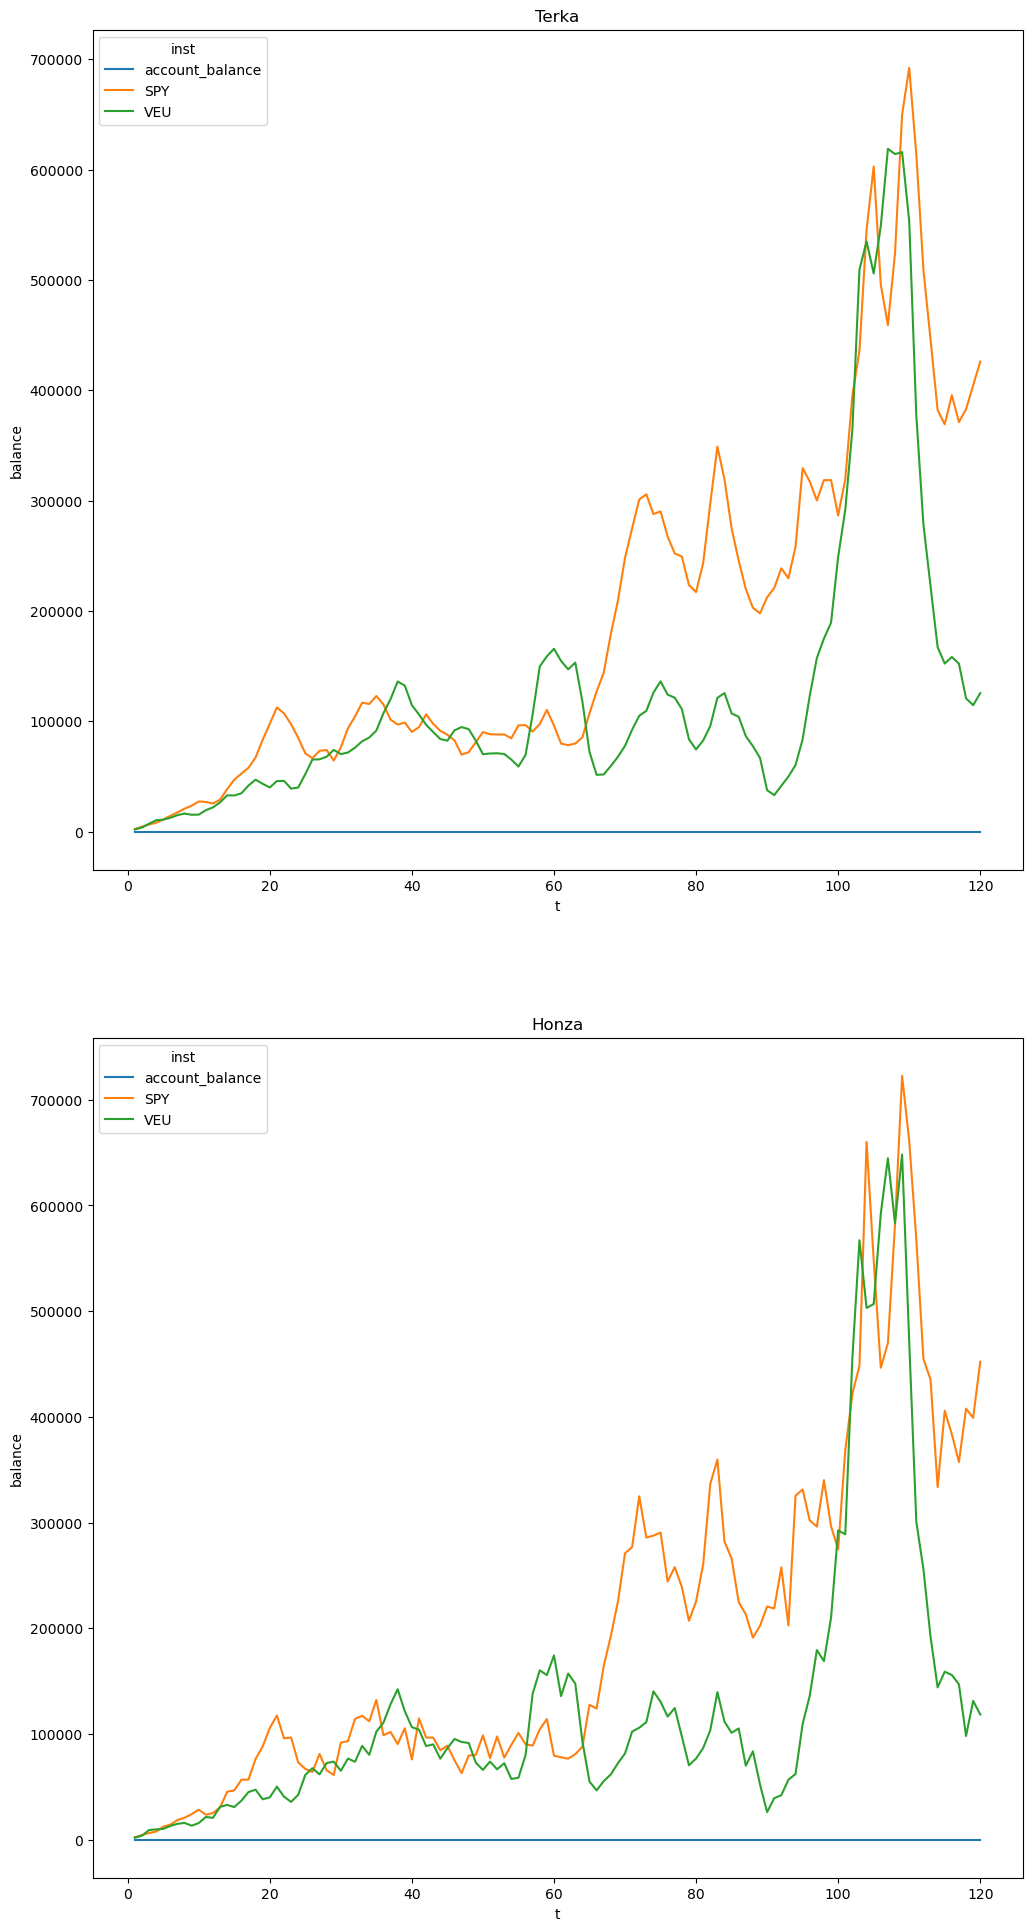

In [8]:
plot1 = dp.plot_all_indexes_for_all_people(plot_width=12, plot_height=24, n_cols=1)

0
n_rows: 2
n_cols: 1
col_n: 0
row_n: 0
1
n_rows: 2
n_cols: 1
col_n: 1
row_n: 1


c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

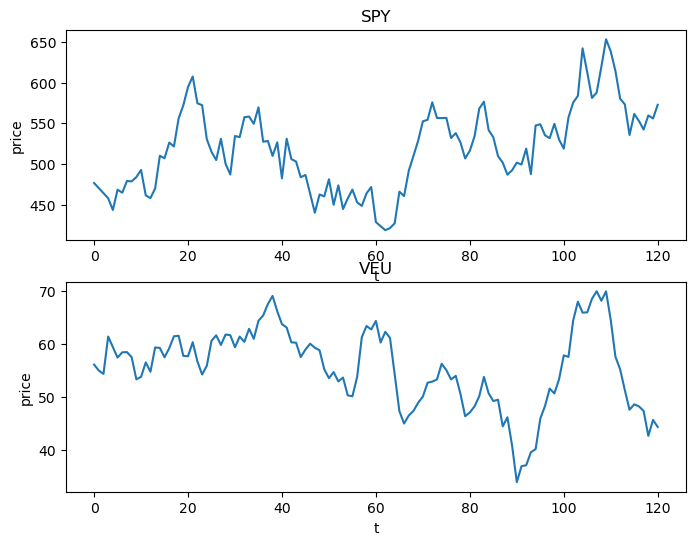

In [9]:
dp.plot_all_indexes_separatedly(n_cols=1)

In [6]:
aa

,inst,balance
0,account_balance,0.0
1,SAP500,17500.0


In [6]:
period_dict=reality_1.person_data

In [15]:
cc = dp.get_period_df(period_dict=reality_1.person_data['Terka'][1])
print(cc)

None


In [11]:
reality_1.person_data

{'Terka': {1: {'amount': 42500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 34562.75113173683}}}},
  2: {'amount': 50000.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 68962.70006913255}}}},
  3: {'amount': 57500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 103334.24817189723}}}},
  4: {'amount': 65000.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 137884.61613423962}}}},
  5: {'amount': 72500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 172511.37961425897}}}},
  6: {'amount': 80000.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 207268.62790743978}}}},
  7: {'amount': 87500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0

In [12]:
reality_1.person_data

{'Terka': {1: {'amount': 42500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 34562.75113173683}}}},
  2: {'amount': 50000.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 68962.70006913255}}}},
  3: {'amount': 57500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 103334.24817189723}}}},
  4: {'amount': 65000.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 137884.61613423962}}}},
  5: {'amount': 72500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 172511.37961425897}}}},
  6: {'amount': 80000.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0,
     'instruments': {'SAP500': 207268.62790743978}}}},
  7: {'amount': 87500.0,
   'income': 25000,
   'age': 26,
   'accounts': {'kb': {'amount': 0

In [7]:
pd.DataFrame.from_dict(reality_1.person_data['Terka'][1]['accounts'])

,kb
amount,0.0
instruments,{'SAP500': 17500.0}


In [84]:
terka.reality.broker_list
reality_1.instrument_data

{'SAP500': [4552.864952380948,
  4552.864952380948,
  4552.864952380948,
  4524.3365,
  4552.864952380948,
  4552.864952380948,
  4533.1858250000005,
  4552.864952380948,
  4552.864952380948,
  4539.083116249999,
  4552.864952380948,
  4552.864952380948,
  4545.4597720625,
  4552.864952380948,
  4552.864952380948,
  4547.9477606656255,
  4552.864952380948,
  4552.864952380948,
  4550.201148698907,
  4552.864952380948,
  4552.864952380948,
  4552.299206133851,
  4552.864952380948,
  4552.864952380948,
  4554.213166440544,
  4552.864952380948,
  4552.864952380948,
  4554.554824762571,
  4552.864952380948,
  4552.864952380948,
  4555.3730660006995,
  4552.864952380948,
  4552.864952380948,
  4555.3107193007345,
  4552.864952380948,
  4552.864952380948,
  4555.109255265771,
  4552.864952380948,
  4552.864952380948,
  4555.343218029059,
  4552.864952380948,
  4552.864952380948,
  4555.365878930512,
  4552.864952380948,
  4552.864952380948,
  4555.605172877038,
  4552.864952380948,
  4552.86

In [5]:
a = Index(name='aa')

In [13]:
reality = Reality()
person = Person(name='ja', starting_age=25, starting_money=0, reality=reality, current_monthly_income=1250)

In [14]:
reality.broker_list.append('kb')

In [31]:
terka.reality.broker_list

['kb']

<Axes: >

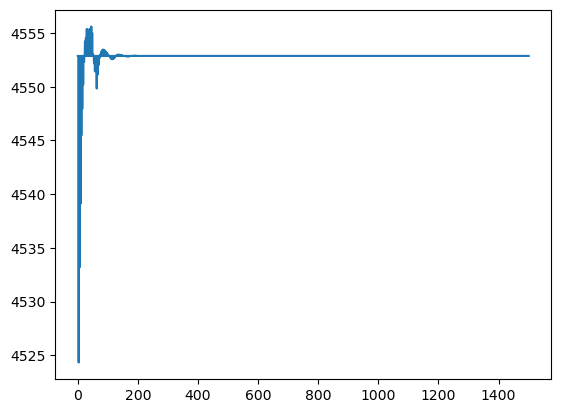

In [87]:
import seaborn as sns
reality_1.instrument_data['SAP500']
x = [i for i in range(len(reality_1.instrument_data['SAP500']))]
sns.lineplot(x=x, y=reality_1.instrument_data['SAP500'])

In [4]:
ind_1 = Index(name='SAP', type_='etf')
acc = Account()

In [45]:
import calendar


In [46]:
calendar.monthrange(2024, 2)

(3, 29)

In [54]:
money = 50000
tax_base = 0
nasporena_castka = 0
for t in range(12):
    money += 1000
    n_days = calendar.monthrange(2024, t + 1)[1]
    print(n_days)
    urok = money * ((6 * (n_days)/36600))
    print(urok)
    tax_base += urok
    nasporena_castka = nasporena_castka + urok + 1000
    money = money + urok
tax = tax_base * 0.15
money = money - tax
money

31
259.18032786885243
29
248.44528352593392
31
271.9239990087276
30
269.4076210347714
31
284.83896297944045
30
281.96948948074294
31
297.88339937718894
31
304.47920025926976
30
301.07276205017183
31
317.72052990379314
30
313.9520733220766
31
331.0946037890394


64959.67301471002

In [55]:
import requests
import scrapy
base_url = 'https://www.cnb.cz/cs/financni-trhy/penezni-trh/pribor/fixing-urokovych-sazeb-na-mezibankovnim-trhu-depozit-pribor/rok.txt?year='

for year in range(1992, 2024):
    url = base_url + str(year)
    html = requests.get(url).content
    selector = scrapy.Selector(text=html)
    data = selector.xpath('//pre/text()')


3481.968252600009

In [17]:
import requests
import scrapy
base_url = 'https://www.cnb.cz/cs/financni-trhy/penezni-trh/pribor/fixing-urokovych-sazeb-na-mezibankovnim-trhu-depozit-pribor/rok.txt?year='
url = base_url + str(2018)
html = requests.get(url).content
print(html)
selector = scrapy.Selector(text=html)
data = selector.xpath('//pre').get()
print(data)
print(type(data))
result = data.split('|')
result

b'|1 den||7 dn\xc3\xad||14 dn\xc3\xad||1 m\xc4\x9bs\xc3\xadc||2 m\xc4\x9bs\xc3\xadce||3 m\xc4\x9bs\xc3\xadce||6 m\xc4\x9bs\xc3\xadc\xc5\xaf||9 m\xc4\x9bs\xc3\xadc\xc5\xaf||1 rok|\nDatum|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR\n02.01.2018||0,50||0,55||0,58||0,64||0,69||0,76||0,85||0,91||0,97\n03.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,85||0,91||0,97\n04.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,85||0,92||0,97\n05.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,85||0,92||0,97\n08.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,86||0,92||0,97\n09.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,86||0,92||0,97\n10.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n11.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n12.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n15.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n16.01.2018||0,50||0,55||0,5

c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\scrapy\selector\unified.py:83: UserWarning: Selector got both text and root, root is being ignored.
  super().__init__(text=text, type=st, root=root, **kwargs)


AttributeError: 'NoneType' object has no attribute 'split'

In [24]:
csv_

[['|1 den||7 dní||14 dní||1 měsíc||2 měsíce||3 měsíce||6 měsíců||9 měsíců||1 rok|'],
 ['Datum|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR'],
 ['02.01.2018||0',
  '50||0',
  '55||0',
  '58||0',
  '64||0',
  '69||0',
  '76||0',
  '85||0',
  '91||0',
  '97'],
 ['03.01.2018||0',
  '50||0',
  '55||0',
  '59||0',
  '64||0',
  '69||0',
  '76||0',
  '85||0',
  '91||0',
  '97'],
 ['04.01.2018||0',
  '50||0',
  '55||0',
  '59||0',
  '64||0',
  '69||0',
  '76||0',
  '85||0',
  '92||0',
  '97'],
 ['05.01.2018||0',
  '50||0',
  '55||0',
  '59||0',
  '64||0',
  '69||0',
  '76||0',
  '85||0',
  '92||0',
  '97'],
 ['08.01.2018||0',
  '50||0',
  '55||0',
  '59||0',
  '64||0',
  '69||0',
  '76||0',
  '86||0',
  '92||0',
  '97'],
 ['09.01.2018||0',
  '50||0',
  '55||0',
  '59||0',
  '64||0',
  '69||0',
  '76||0',
  '86||0',
  '92||0',
  '97'],
 ['10.01.2018||0',
  '50||0',
  '55||0',
  '59||0',
  '65||0',
  '70||0',
  '76||

In [29]:
csv_string = html.decode('utf-8')
csv_string

'|1 den||7 dní||14 dní||1 měsíc||2 měsíce||3 měsíce||6 měsíců||9 měsíců||1 rok|\nDatum|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR\n02.01.2018||0,50||0,55||0,58||0,64||0,69||0,76||0,85||0,91||0,97\n03.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,85||0,91||0,97\n04.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,85||0,92||0,97\n05.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,85||0,92||0,97\n08.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,86||0,92||0,97\n09.01.2018||0,50||0,55||0,59||0,64||0,69||0,76||0,86||0,92||0,97\n10.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n11.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n12.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n15.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n16.01.2018||0,50||0,55||0,59||0,65||0,70||0,76||0,86||0,92||0,97\n17.01.2018||0,50||0,55||0,59||0,65||0,70||0,77||0,86||0,93||

In [34]:
from io import StringIO
import pandas as pd
data = csv_string.replace('||', '|')

# Use StringIO to simulate reading from a file-like object
df = pd.read_csv(StringIO(data), sep='|', index_col=0)

ParserError: Could not construct index. Requested to use 1 number of columns, but 8 left to parse.

In [42]:
data = data.split('\n')
data

AttributeError: 'list' object has no attribute 'split'

In [43]:
data

['|1 den|7 dní|14 dní|1 měsíc|2 měsíce|3 měsíce|6 měsíců|9 měsíců|1 rok|',
 'Datum|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR',
 '02.01.2018|0,50|0,55|0,58|0,64|0,69|0,76|0,85|0,91|0,97',
 '03.01.2018|0,50|0,55|0,59|0,64|0,69|0,76|0,85|0,91|0,97',
 '04.01.2018|0,50|0,55|0,59|0,64|0,69|0,76|0,85|0,92|0,97',
 '05.01.2018|0,50|0,55|0,59|0,64|0,69|0,76|0,85|0,92|0,97',
 '08.01.2018|0,50|0,55|0,59|0,64|0,69|0,76|0,86|0,92|0,97',
 '09.01.2018|0,50|0,55|0,59|0,64|0,69|0,76|0,86|0,92|0,97',
 '10.01.2018|0,50|0,55|0,59|0,65|0,70|0,76|0,86|0,92|0,97',
 '11.01.2018|0,50|0,55|0,59|0,65|0,70|0,76|0,86|0,92|0,97',
 '12.01.2018|0,50|0,55|0,59|0,65|0,70|0,76|0,86|0,92|0,97',
 '15.01.2018|0,50|0,55|0,59|0,65|0,70|0,76|0,86|0,92|0,97',
 '16.01.2018|0,50|0,55|0,59|0,65|0,70|0,76|0,86|0,92|0,97',
 '17.01.2018|0,50|0,55|0,59|0,65|0,70|0,77|0,86|0,93|0,98',
 '18.01.2018|0,50|0,55|0,59|0,65|0,70|0,77|0,86|0,93|0,98',
 '19.01.2

In [82]:
import requests
base_url = 'https://www.cnb.cz/cs/financni-trhy/penezni-trh/pribor/fixing-urokovych-sazeb-na-mezibankovnim-trhu-depozit-pribor/rok.txt?year='
url = base_url + str(1992)
html = requests.get(url).content
csv_string = html.decode('utf-8')
data = csv_string.replace('||', '|')
data = data.split('\n')
for ind in range(len(data)):
    print(data[ind])
    updated = data[ind].split("|")
    data[ind] = updated
data = [row for row in data if len(row) > 4]
print(data)
data[0].pop()
del data[1]
data[0][0] = 'Datum'

df = pd.DataFrame(data[1:len(data)- 1], columns=data[0])
df
    

|1 den|7 dní|14 dní|1 měsíc|2 měsíce|3 měsíce|6 měsíců|9 měsíců|1 rok|
Datum|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR|PRIBID|PRIBOR
22.04.1992|5,56|7,19|6,94|8,56|8,63|8,00|9,75||8,69|10,44|9,38|11,38|11,50|13,50
23.04.1992|5,50|7,31|6,31|8,00|8,13|7,44|9,44||8,44|10,44|9,81|11,94|12,00|14,00
24.04.1992|4,50|6,50|5,25|7,13|5,50|7,44|7,06|8,75||7,38|9,63|10,69|
27.04.1992|4,00|5,63|5,38|7,00|6,00|7,50|7,50|8,88||8,38|10,13|9,50|11,31|11,13|13,38
28.04.1992|4,13|5,69|5,19|6,94|7,13|7,00|8,69||7,81|9,88|9,50|11,25|11,75|13,75
29.04.1992|4,50|6,50|5,31|7,25|5,88|7,56|7,31|9,25||8,56|10,44|9,63|11,56|11,13|13,13
30.04.1992|5,00|6,63|5,81|7,31|5,94|7,56|6,88|8,69||8,25|10,13|12,13|11,75|13,50
04.05.1992|5,13|6,63|6,38|7,88|6,94|8,50|7,88|9,38||8,94|10,44|9,88|11,25|
05.05.1992|5,00|6,88|6,19|7,81|6,19|8,06|7,88|9,50||8,50|10,44|9,69|11,38|
06.05.1992|5,25|7,19|6,31|7,88|6,56|8,44|7,44|9,19||9,00|10,63|10,50|11,94|12,50|14

ValueError: 10 columns passed, passed data had 16 columns

In [165]:
def get_year_df(year):
    import requests
    base_url = 'https://www.cnb.cz/cs/financni-trhy/penezni-trh/pribor/fixing-urokovych-sazeb-na-mezibankovnim-trhu-depozit-pribor/rok.txt?year='
    url = base_url + str(year)
    html = requests.get(url).content
    csv_string = html.decode('utf-8')
    data = csv_string.replace('||', '|')
    data = data.split('\n')
    data = [row for row in data if len(row) > 4]
    for ind in range(len(data)):
        updated = data[ind].split("|")
        data[ind] = updated
    data[0].pop()
    del data[1]
    data[0][0] = 'Datum'
    for ind in range(len(data)):
        updated = data[ind]
        if len(data[ind]) > 15:
            updated = [updated[0]] + updated[2::2]
        data[ind] = updated
    data = [row[0:10] for row in data]
    print(data)
    df = pd.DataFrame(data[1:len(data)- 1], columns=data[0])
    print('done')
    return df
    

In [174]:
def replace_commas_and_convert(value):
    if value is pd.NA:
        return value
    return float(value.replace(',', '.'))
def get_repo_df():
    columns = ['Datum', '1 den', '7 dní', '14 dní', '1 měsíc', '2 měsíce', 
               '3 měsíce', '6 měsíců', '9 měsíců', '1 rok']
    df = pd.DataFrame(columns=columns)
    for year in range(1992, 2024):
        year_df =  get_year_df(year=year)
        df = pd.concat([df, year_df], axis=0)

    df = df.replace('', pd.NA)
    df = df.fillna(pd.NA)
    print(df.head())
    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(replace_commas_and_convert)
    df['Datum'] = pd.to_datetime(df_all['Datum'], format='%d.%m.%Y')
    return df


In [175]:
df_all = get_repo_df()
df_all

[['Datum', '1 den', '7 dní', '14 dní', '1 měsíc', '2 měsíce', '3 měsíce', '6 měsíců', '9 měsíců', '1 rok'], ['22.04.1992', '5,56', '7,19', '6,94', '8,56', '8,63', '8,00', '9,75', '', '8,69'], ['23.04.1992', '5,50', '7,31', '6,31', '8,00', '8,13', '7,44', '9,44', '', '8,44'], ['24.04.1992', '4,50', '6,50', '5,25', '7,13', '5,50', '7,44', '7,06', '8,75', ''], ['27.04.1992', '5,63', '7,00', '7,50', '8,88', '8,38', '9,50', '11,13'], ['28.04.1992', '4,13', '5,69', '5,19', '6,94', '7,13', '7,00', '8,69', '', '7,81'], ['29.04.1992', '6,50', '7,25', '7,56', '9,25', '8,56', '9,63', '11,13'], ['30.04.1992', '5,00', '6,63', '5,81', '7,31', '5,94', '7,56', '6,88', '8,69', ''], ['04.05.1992', '5,13', '6,63', '6,38', '7,88', '6,94', '8,50', '7,88', '9,38', ''], ['05.05.1992', '5,00', '6,88', '6,19', '7,81', '6,19', '8,06', '7,88', '9,50', ''], ['06.05.1992', '7,19', '7,88', '8,44', '9,19', '9,00', '10,50', '12,50'], ['07.05.1992', '7,38', '8,00', '8,38', '9,25', '8,88', '10,50', '12,50'], ['11.05.19

C:\Users\jziac\AppData\Local\Temp\ipykernel_12732\3744958256.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(replace_commas_and_convert)


,Datum,1 den,7 dní,14 dní,1 měsíc,2 měsíce,3 měsíce,6 měsíců,9 měsíců,1 rok
0,22.04.1992,5.56,7.19,6.94,8.56,8.63,8.0,9.75,<NA>,8.69
1,23.04.1992,5.5,7.31,6.31,8.0,8.13,7.44,9.44,<NA>,8.44
2,24.04.1992,4.5,6.5,5.25,7.13,5.5,7.44,7.06,8.75,<NA>
3,27.04.1992,5.63,7.0,7.5,8.88,8.38,9.5,11.13,<NA>,<NA>
4,28.04.1992,4.13,5.69,5.19,6.94,7.13,7.0,8.69,<NA>,7.81
...,...,...,...,...,...,...,...,...,...,...
243,19.12.2023,7.0,7.02,7.04,7.0,7.0,6.99,6.71,6.38,6.18
244,20.12.2023,7.0,7.02,7.04,7.0,7.0,6.99,6.7,6.38,6.18
245,21.12.2023,7.0,7.02,7.03,7.0,7.0,6.99,6.69,6.37,6.17
246,22.12.2023,6.75,6.77,6.79,6.81,6.8,6.78,6.52,6.16,5.88


c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


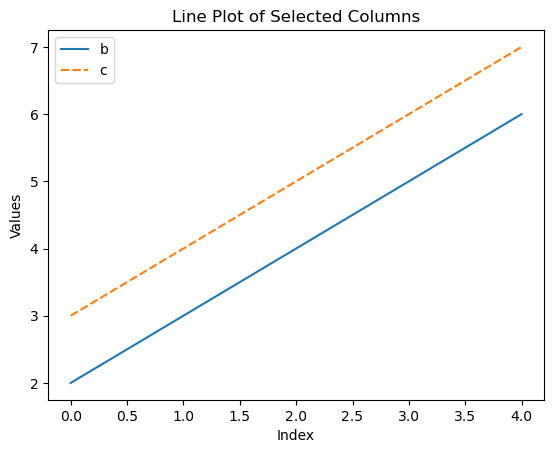

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a sample DataFrame
data = {'a': [1, 2, 3, 4, 5],
        'b': [2, 3, 4, 5, 6],
        'c': [3, 4, 5, 6, 7],
        'd': [4, 5, 6, 7, 8]}
df = pd.DataFrame(data)

# Select the second to the last columns
columns_to_plot = df.columns[1:-1]

# Plot selected columns as lines in one plot
sns.lineplot(data=df[columns_to_plot])

# Customize the plot (optional)
plt.title('Line Plot of Selected Columns')
plt.xlabel('Index')
plt.ylabel('Values')

# Show the plot
plt.show()

In [108]:
df_all = pd.read_csv('repo.csv', index_col=0)
df_all["Datum"] = pd.to_datetime(df_all["Datum"])
df_all.set_index("Datum", inplace=True)
df_all

,1 den,7 dní,14 dní,1 měsíc,2 měsíce,3 měsíce,6 měsíců,9 měsíců,1 rok
Datum,,,,,,,,,
1992-04-22,5.56,7.19,6.94,8.56,8.63,8.00,9.75,NaN,8.69
1992-04-23,5.50,7.31,6.31,8.00,8.13,7.44,9.44,NaN,8.44
1992-04-24,4.50,6.50,5.25,7.13,5.50,7.44,7.06,8.75,NaN
1992-04-27,5.63,7.00,7.50,8.88,8.38,9.50,11.13,NaN,NaN
1992-04-28,4.13,5.69,5.19,6.94,7.13,7.00,8.69,NaN,7.81
...,...,...,...,...,...,...,...,...,...
2023-12-19,7.00,7.02,7.04,7.00,7.00,6.99,6.71,6.38,6.18
2023-12-20,7.00,7.02,7.04,7.00,7.00,6.99,6.70,6.38,6.18
2023-12-21,7.00,7.02,7.03,7.00,7.00,6.99,6.69,6.37,6.17


In [101]:
df_all = pd.read_csv('repo.csv', index_col=0)
df_all

,Datum,1 den,7 dní,14 dní,1 měsíc,2 měsíce,3 měsíce,6 měsíců,9 měsíců,1 rok
0,1992-04-22,5.56,7.19,6.94,8.56,8.63,8.00,9.75,NaN,8.69
1,1992-04-23,5.50,7.31,6.31,8.00,8.13,7.44,9.44,NaN,8.44
2,1992-04-24,4.50,6.50,5.25,7.13,5.50,7.44,7.06,8.75,NaN
3,1992-04-27,5.63,7.00,7.50,8.88,8.38,9.50,11.13,NaN,NaN
4,1992-04-28,4.13,5.69,5.19,6.94,7.13,7.00,8.69,NaN,7.81
...,...,...,...,...,...,...,...,...,...,...
243,2023-12-19,7.00,7.02,7.04,7.00,7.00,6.99,6.71,6.38,6.18
244,2023-12-20,7.00,7.02,7.04,7.00,7.00,6.99,6.70,6.38,6.18
245,2023-12-21,7.00,7.02,7.03,7.00,7.00,6.99,6.69,6.37,6.17
246,2023-12-22,6.75,6.77,6.79,6.81,6.80,6.78,6.52,6.16,5.88


c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

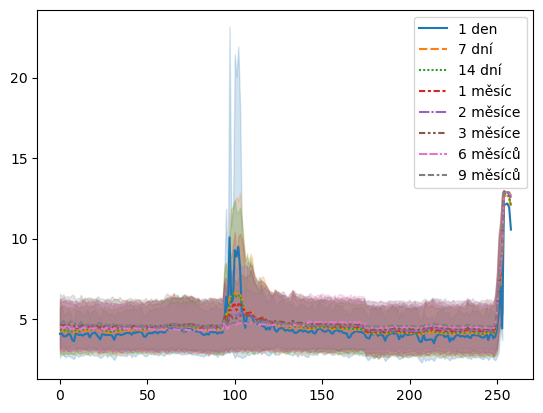

In [29]:
columns_to_plot = df_all.columns[1:-1]
sns.lineplot(data=df_all[columns_to_plot])

c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 25.0)

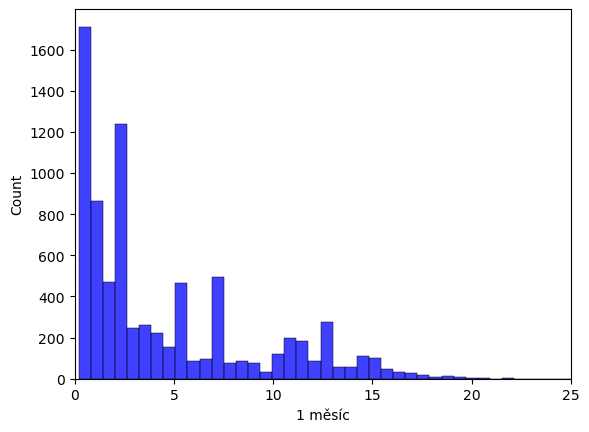

In [32]:
import matplotlib.pyplot as plt
sns.histplot(data=df_all, x='1 měsíc', bins='auto', kde=False, color='blue')
plt.xlim(0, 25)

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, weibull_max, expon, lognorm, weibull_min, pareto, laplace, cauchy, beta,  gamma, logistic, rayleigh, exponweib, genextreme, kstest

# Generate some sample data (replace this with your actual data)
repo_pct =  df_all[df_all.index > '2012-11-01']['1 měsíc'].dropna()
data = np.array(repo_pct, dtype=float)

# Fit different distributions and compare using the Kolmogorov-Smirnov test
distributions = [norm, weibull_max, weibull_min, expon, lognorm, pareto, laplace, cauchy, beta,  gamma, logistic, rayleigh, exponweib, genextreme]
best_fit = None
best_params = None
best_ks_stat = float('inf')

for distribution in distributions:
    # Fit the distribution to the data
    params = distribution.fit(data)
    
    # Compute the Kolmogorov-Smirnov test statistic
    ks_stat, _ = kstest(data, distribution.cdf, params)
    
    # Update the best fit if the current distribution has a lower KS statistic
    if ks_stat < best_ks_stat:
        best_fit = distribution
        best_params = params
        best_ks_stat = ks_stat

c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [131]:
best_fit

In [97]:
df_all.set_index('Datum', inplace=True)
df_all.resample('M').first()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [133]:
data_expo= genextreme.rvs(a=2, b=4, loc=6, scale=8, size=1000000)
beta.fit(data_expo)

TypeError: _parse_args_rvs() got an unexpected keyword argument 'b'

In [49]:
df_all[df_all['Datum'] > '2002-11-01']

,Datum,1 den,7 dní,14 dní,1 měsíc,2 měsíce,3 měsíce,6 měsíců,9 měsíců,1 rok
211,2002-11-04,2.77,2.78,2.78,2.78,2.78,2.77,2.75,2.75,2.75
212,2002-11-05,2.78,2.78,2.78,2.78,2.78,2.77,2.75,2.75,2.75
213,2002-11-06,2.76,2.79,2.79,2.78,2.78,2.78,2.76,2.76,2.77
214,2002-11-07,2.77,2.78,2.78,2.78,2.78,2.79,2.77,2.77,2.77
215,2002-11-08,2.77,2.78,2.78,2.78,2.78,2.78,2.76,2.76,2.77
...,...,...,...,...,...,...,...,...,...,...
243,2023-12-19,7.00,7.02,7.04,7.00,7.00,6.99,6.71,6.38,6.18
244,2023-12-20,7.00,7.02,7.04,7.00,7.00,6.99,6.70,6.38,6.18
245,2023-12-21,7.00,7.02,7.03,7.00,7.00,6.99,6.69,6.37,6.17
246,2023-12-22,6.75,6.77,6.79,6.81,6.80,6.78,6.52,6.16,5.88


1788
[0.33611714751740596, 0.47591829906029026, 0.18999999999999997, 6.991266430392269]


c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

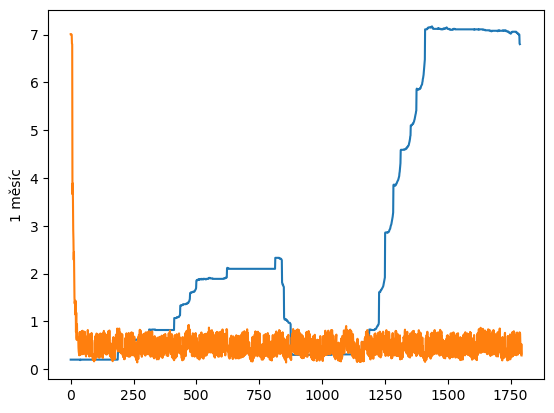

In [127]:
for n_mean in [-7]:
    generate_repo_series(n_mean, 0.6) 


In [126]:
def generate_repo_series(n_mean, coeff):
    repo_prices = df_all[df_all.index > '2016-11-01']['1 měsíc'].dropna()
    length = repo_prices.shape[0]
    print(length)
    a, b, loc, scale = beta.fit(np.array(repo_prices, dtype=float))
    print([a, b, loc, scale])
    gen_pct = beta.rvs(a=a,
                        b=b,
                        loc=loc, 
                            scale=scale, 
                            size=length)
    X = [i for i in range(length)]
    price_list  = list(repo_prices[n_mean:])
    sns.lineplot(x=X, y= repo_prices)
    for i in range(len(gen_pct)):
        calc_list = price_list[n_mean:] + [gen_pct[i]]
        final_price = (sum(calc_list)/len(calc_list)) * coeff
        price_list.append(final_price)
    X = [i for i in range(len(price_list))]
    sns.lineplot(x=X, y= price_list)
    

[7.0, 7.0, 6.81, 6.8]
3.4402665291056556
[7.0, 7.0, 6.81, 6.8, 3.4402665291056556]
3.767157769522703
[7.0, 6.81, 6.8, 3.4402665291056556, 3.767157769522703]
3.008568264656631
[6.81, 6.8, 3.4402665291056556, 3.767157769522703, 3.008568264656631]
2.0649550550845177
[6.8, 3.4402665291056556, 3.767157769522703, 3.008568264656631, 2.0649550550845177]
1.6292750137234824
[3.4402665291056556, 3.767157769522703, 3.008568264656631, 2.0649550550845177, 1.6292750137234824]
1.7423550172657272
[3.767157769522703, 3.008568264656631, 2.0649550550845177, 1.6292750137234824, 1.7423550172657272]
1.63019291801305
[3.008568264656631, 2.0649550550845177, 1.6292750137234824, 1.7423550172657272, 1.63019291801305]
1.7159992504390167
[2.0649550550845177, 1.6292750137234824, 1.7423550172657272, 1.63019291801305, 1.7159992504390167]
1.0744952535691359
[1.6292750137234824, 1.7423550172657272, 1.63019291801305, 1.7159992504390167, 1.0744952535691359]
1.62266046261593
[1.7423550172657272, 1.63019291801305, 1.7159992

c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\scipy\stats\_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opt

<Axes: >

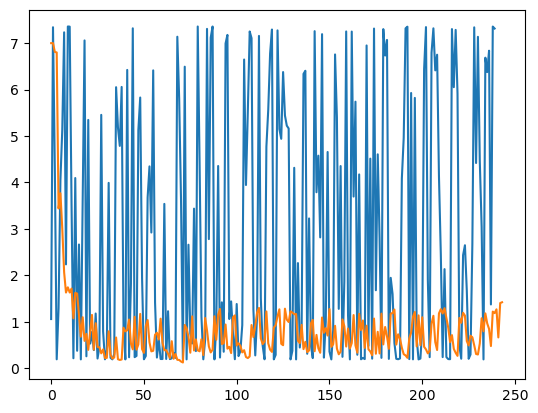

In [121]:
from scipy.stats import t, norm
import seaborn as sns
import numpy as np
length = 240
n_mean= -4
coeff = 0.6
repo_prices = df_all[df_all.index > '2012-11-01']['1 měsíc'].dropna()
a, b, loc, scale = beta.fit(np.array(repo_prices, dtype=float))
gen_pct = beta.rvs(a=a,
                       b=b,
                       loc=loc, 
                        scale=scale, 
                        size=length)
X = [i for i in range(length)]
price_list  = list(repo_prices[n_mean:])
sns.lineplot(x=X, y= gen_pct)
for i in range(len(gen_pct)):
    calc_list = price_list[n_mean:] + [gen_pct[i]]
    print(price_list[-5:])
    final_price = (sum(calc_list)/len(calc_list)) * coeff
    print(final_price)
    price_list.append(final_price)
X = [i for i in range(len(price_list))]
sns.lineplot(x=X, y= price_list)

c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

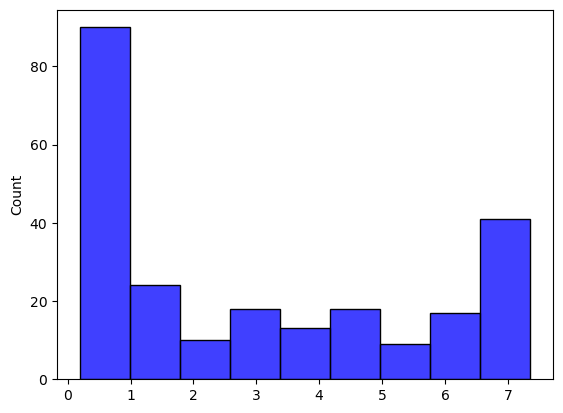

In [110]:
sns.histplot(x=gen_pct, bins='auto', kde=False, color='blue')

In [255]:
price_list

[7,
 6.75,
 6.75,
 7.498205134884818,
 8.24312451996429,
 5.628915220310558,
 5.1019671917341896,
 7.936088946461355,
 8.027831720290665,
 6.8227615070523795,
 6.326036538410344,
 7.429484377069489,
 6.367777598894745,
 3.8240577716370368,
 5.2225104529038475,
 3.2688849104117876,
 4.922402558503321,
 2.081863224841446,
 3.067398735413729,
 5.038151156541551,
 2.8344493354162132,
 4.614204244826925,
 5.732475689162847,
 3.516060945507615,
 1.1113752145332256,
 3.770457489353419,
 2.3237168082617194,
 1.541173586263971,
 2.3113785819557875,
 3.5499615525803483,
 4.936609062514265,
 3.0514437966494885,
 7.085782945214763,
 5.277130413266816,
 2.821797766100845,
 8.20425283063124,
 4.712568677170945,
 4.663712684799178,
 4.145369955552545,
 3.5312938247156134,
 1.9764038839304796,
 5.724284313570552,
 4.42349800611427,
 2.6400565116641026,
 3.4385046111078967,
 2.771202415390772,
 2.560530892565269,
 5.981490580420474,
 3.7329865962589763,
 6.304345876839983,
 5.123300752197141,
 4.198608

In [193]:
repo_pct

1     -0.010791
2     -0.181818
3      0.251111
4     -0.266430
5      0.573850
         ...   
243    0.000000
244    0.000000
245    0.000000
246   -0.035714
247    0.000000
Name: 1 den, Length: 7962, dtype: float64

In [195]:
percentage_list  = []
curr_perc = 6.75
for i in range(len(curr_return)):
    curr_perc = (curr_return[i] + 1) * curr_perc
    percentage_list.append(curr_perc)

c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jziac\miniforge3\envs\p-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

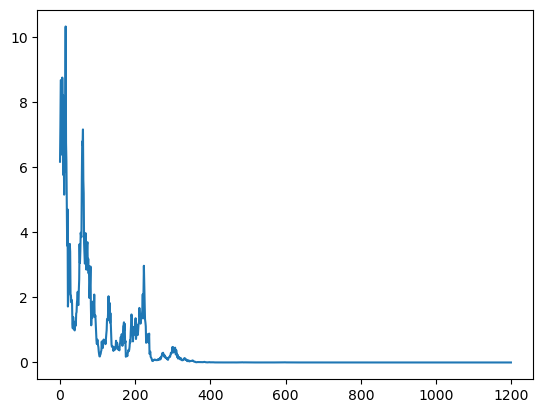

In [198]:
sns.lineplot(x=X, y= percentage_list)

<Axes: xlabel='Datum'>

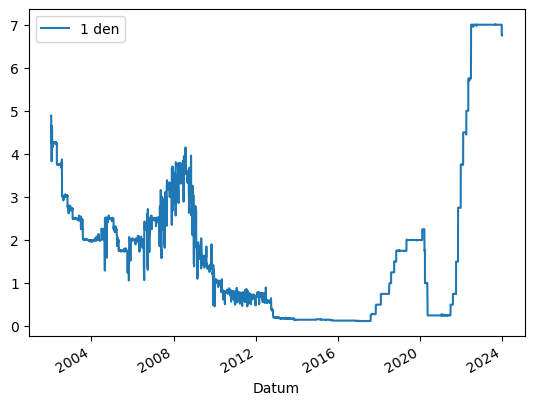

In [180]:
df_all[df_all['Datum'] > '01.12.2002'].plot(x='Datum', y= '1 den')


In [181]:
df_all.to_csv('repo.csv')

In [95]:
for i in range(len(data)):
    if len(data[i]) != 10:
        print(len(data[i]))

15
15
14
16
15
16
15
15
15
16
16
15
15
16
16
16
16
16
16
16
16
16
15
15
16
14
16
16
16
16
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


In [87]:
data[0]

['Datum',
 '1 den',
 '7 dní',
 '14 dní',
 '1 měsíc',
 '2 měsíce',
 '3 měsíce',
 '6 měsíců',
 '9 měsíců',
 '1 rok']